In [1]:
from __future__ import annotations
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass
import graphviz
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random
from pprint import pprint
from typing import (Callable, Dict, Iterable, Generic, Sequence, Tuple,
                    Mapping, TypeVar, Set)

from rl.distribution import (Categorical, Distribution,
                            Gaussian, Choose, Constant, FiniteDistribution)
from rl.markov_process import (MarkovProcess, FiniteMarkovProcess, NonTerminal, Terminal, State,
                                FiniteMarkovRewardProcess)

from typing import Mapping, Dict

## Markov Process

State Space: 100 locations on a 10x10 game board.

Transition Probabilities: Equal probability of moving [1,2,3,4,5,6] steps ahead, combined with small probability of taking an additional [3,5,7,10] steps backwards or [2,3,5,7] steps forward. 

In [2]:
@dataclass(frozen=True)
class Die(Distribution[int]):
    sides: int
    def sample(self) -> int:
        return random.randint(1, self.sides)
    
    def expectation(self) -> int:
        return (int + 1) / 2

@dataclass(frozen=True)
class StateSaL:
    position: int
    
@dataclass
class SnakesandLadders(MarkovProcess[StateSaL]):
    # Create a distribution (a 6-sided die)
    six_sided = Die(6)
    snake = Choose([-10,-7,-5,-3])
    ladder = Choose([2,3,5,7])
    
    
    def transition(self, state: NonTerminal[StateSaL]) -> Categorical[State[StateSaL]]:
        die_roll = self.six_sided.sample()
        snake_s = self.snake.sample()
        ladder_s = self.ladder.sample()
        
        return Categorical({
            NonTerminal(StateSaL(state.state.position + die_roll)): 0.60,
            NonTerminal(StateSaL(state.state.position + die_roll + snake_s)): 0.20,
            NonTerminal(StateSaL(state.state.position + die_roll + ladder_s)): 0.20,
        })

In [3]:
def run_game(time_steps: int, num_traces: int) -> np.ndarray:
    mp = SnakesandLadders()
    start_state_distribution = Constant(NonTerminal(StateSaL(position=0)))
    
    return np.vstack([
        np.fromiter((s.state.position for s in itertools.islice(
            mp.simulate(start_state_distribution),
            time_steps + 1)), float) for _ in range(num_traces)])

In [4]:
game_traces: np.ndarray = run_game(
        time_steps=20,
        num_traces=10
    )

Text(0.5, 1.0, 'Location on Board')

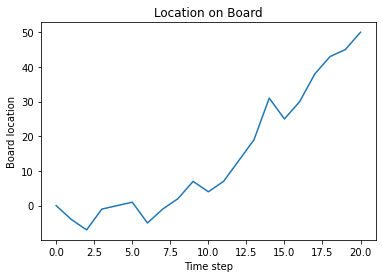

In [5]:
trace1 = game_traces[0]

plt.plot(trace1)
plt.ylabel("Board location")
plt.xlabel("Time step")
plt.title("Location on Board")

## Finite Markov Process

In [6]:

@dataclass(frozen=True)
class SaLState:
    position: int

    def get_position(self) -> int:
        return self.position


class SnakesandLaddersFinite(FiniteMarkovProcess[SaLState]):

    def __init__(self, board_size: int,):
        self.size: int = board_size
    
        # See above for Die distribution
        self.distr = Die(6)
        
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Mapping[SaLState, FiniteDistribution[SaLState]]:
        mymap: Dict[SaLState, Categorical[SaLState]] = {}
        
     
    
        for current_pos in range(self.size):
            current_state = SaLState(current_pos)
            
            # Probabilities just from the die rolls
            die_roll_map: Mapping[SaLState, float] = {
                SaLState(possible_pos): (1/6) * 0.8
                for possible_pos in range(current_pos+1, current_pos + 6)
                
            }
            
            # Probabilities from the snakes and ladders
            snake_and_ladder_map: Mapping[SaLState, float] = {
                SaLState(current_pos + offset): (1/5) * 0.2
                for offset in [-7,-5,-3,7,9] if (current_pos + offset >=0 and current_pos + offset <= self.size)
            }
            
            die_roll_map.update(snake_and_ladder_map)
            
            mymap[SaLState(current_pos)] = Categorical(die_roll_map)
        return mymap
    


# if __name__ == '__main__':
#     si_mp = SnakesandLaddersFinite(board_size=100)

#     print("Transition Map")
#     print("--------------")
#     print(si_mp)

#     print("Stationary Distribution")
#     print("-----------------------")
#     si_mp.display_stationary_distribution()


### Transition Map

In [7]:
Board1 = SnakesandLaddersFinite(board_size=100)

In [8]:
print("Transition Map")
print("--------------")
print(Board1)

Transition Map
--------------
From State SaLState(position=0):
  To State SaLState(position=1) with Probability 0.179
  To State SaLState(position=2) with Probability 0.179
  To State SaLState(position=3) with Probability 0.179
  To State SaLState(position=4) with Probability 0.179
  To State SaLState(position=5) with Probability 0.179
  To State SaLState(position=7) with Probability 0.054
  To State SaLState(position=9) with Probability 0.054
From State SaLState(position=1):
  To State SaLState(position=2) with Probability 0.179
  To State SaLState(position=3) with Probability 0.179
  To State SaLState(position=4) with Probability 0.179
  To State SaLState(position=5) with Probability 0.179
  To State SaLState(position=6) with Probability 0.179
  To State SaLState(position=8) with Probability 0.054
  To State SaLState(position=10) with Probability 0.054
From State SaLState(position=2):
  To State SaLState(position=3) with Probability 0.179
  To State SaLState(position=4) with Probabil

### Histogram

In [9]:
keys = list(Board1.transition_map.keys())
start_dist = Categorical({keys[0]:1})

In [10]:
traces = itertools.islice(Board1.traces(start_dist), 100000)

steps_per_trace = []
for trace in traces:
    steps = len(list(trace))
    steps_per_trace += [steps]

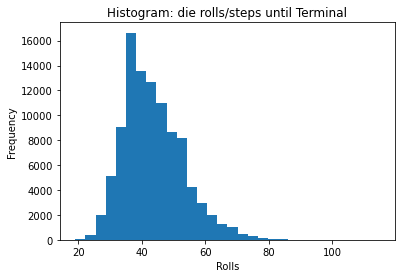

In [11]:
plt.hist(steps_per_trace, bins=30)
plt.title("Histogram: die rolls/steps until Terminal")
plt.ylabel("Frequency")
plt.xlabel("Rolls")
plt.show()

## Frog Puzzle

In [12]:
@dataclass(frozen=True)
class FrogState:
    position: int

class FrogPuzzle(FiniteMarkovProcess[FrogState]):

    def __init__(self, end: int,):
        self.end: int = end
    
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Mapping[FrogState, FiniteDistribution[FrogState]]:
        mymap: Dict[FrogState, Categorical[FrogState]] = {}
        
        for position in range(self.end):
            
            # Possibilities:
            transition_map: Mapping[FrogState, float] = {
                FrogState(possible_pos): 1 / (self.end+1-position)
                for possible_pos in range(position+1, self.end+1)
                
            }
            mymap[FrogState(position)] = Categorical(transition_map)
        return mymap

In [13]:
FrogGame = FrogPuzzle(end=10)

Expectation: 3.9341399999993945


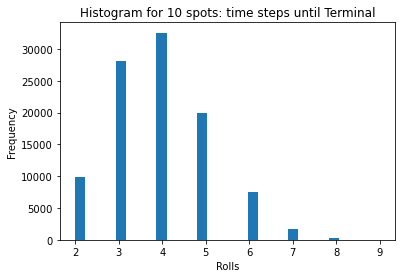

In [14]:
keys = list(FrogGame.transition_map.keys())
start_dist = Categorical({keys[0]:1})

num_traces = 100000
traces = itertools.islice(FrogGame.traces(start_dist), num_traces)

steps_per_trace = []
expectation = 0
for trace in traces:
    steps = len(list(trace))
    steps_per_trace += [steps]
    expectation += (steps * 1/num_traces)
    
print("Expectation: " + str(expectation))
    
plt.hist(steps_per_trace, bins=30)
plt.title("Histogram for 10 spots: time steps until Terminal")
plt.ylabel("Frequency")
plt.xlabel("Rolls")
plt.show()

In [15]:

num_spots = []
expectation_for_given_num_spots = []
for i in range(10,30):
    FrogGame = FrogPuzzle(end=i)
    
    keys = list(FrogGame.transition_map.keys())
    start_dist = Categorical({keys[0]:1})

    num_traces = 10000
    traces = itertools.islice(FrogGame.traces(start_dist), num_traces)

    steps_per_trace = []
    expectation = 0
    for trace in traces:
        steps = len(list(trace))
        steps_per_trace += [steps]
        expectation += (steps * 1/num_traces)

    print("Expectation for " + str(i) + " spots: " + str(expectation))
    
    num_spots += [i]
    expectation_for_given_num_spots += [expectation]

Expectation for 10 spots: 3.929800000000181
Expectation for 11 spots: 4.017400000000188
Expectation for 12 spots: 4.1062000000001815
Expectation for 13 spots: 4.176700000000183
Expectation for 14 spots: 4.265100000000178
Expectation for 15 spots: 4.307700000000179
Expectation for 16 spots: 4.374900000000177
Expectation for 17 spots: 4.431300000000187
Expectation for 18 spots: 4.494500000000182
Expectation for 19 spots: 4.542600000000184
Expectation for 20 spots: 4.5891000000001805
Expectation for 21 spots: 4.672800000000156
Expectation for 22 spots: 4.694400000000181
Expectation for 23 spots: 4.7443000000001785
Expectation for 24 spots: 4.776500000000171
Expectation for 25 spots: 4.838900000000176
Expectation for 26 spots: 4.884300000000191
Expectation for 27 spots: 4.908900000000162
Expectation for 28 spots: 4.904400000000169
Expectation for 29 spots: 4.9649000000001875


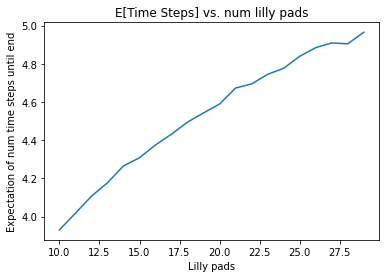

In [16]:
plt.plot(num_spots, expectation_for_given_num_spots)
plt.xlabel("Lilly pads")
plt.ylabel("Expectation of num time steps until end")
plt.title("E[Time Steps] vs. num lilly pads")
plt.show()

## Finite Markov Reward Process 

#### Rewards model should just be 1 unit per time step. Hence, The "expected reward" is just the expected number of time steps until the Markov Reward Process hits a terminal state".

#### No discounting, so gamma=1. 

#### Value function shows the summed future rewards (ie: time steps until completion) for every given state in our model.

In [17]:
class SnakesandLaddersReward(FiniteMarkovRewardProcess[SaLState]):

    def __init__(self, size: int):
        self.size: int = size
        
        super().__init__(self.get_transition_reward_map())

    def get_transition_reward_map(self) -> \
            Mapping[SaLState, FiniteDistribution[Tuple[SaLState, float]]]:
        
        mymap: Dict[SaLState, Categorical[Tuple[SaLState, float]]] = {}
        
        for current_pos in range(self.size):
            state = SaLState(current_pos)

            die_roll_map: Mapping[SaLState, float] = {
                (SaLState(possible_pos), 1): (1/6) * 0.8
                for possible_pos in range(current_pos+1, current_pos + 6)
                
            }
            
            # Probabilities from the snakes and ladders
            snake_and_ladder_map: Mapping[SaLState, float] = {
                (SaLState(current_pos + offset), 1): (1/5) * 0.2
                for offset in [-7,-5,-3,7,9] if (current_pos + offset >=0 and current_pos + offset <= self.size)
            }
            
            
            die_roll_map.update(snake_and_ladder_map)

            mymap[state] = Categorical(die_roll_map)
        return mymap

In [18]:
si_mrp = SnakesandLaddersReward(size=100)

# print("Transition Map")
# print("--------------")
# print(FiniteMarkovProcess(
#     {s.state: Categorical({s1.state: p for s1, p in v.table().items()})
#      for s, v in si_mrp.transition_map.items()}
# ))

# print("Transition Reward Map")
# print("---------------------")
# print(si_mrp)

# print("Reward Function")
# print("---------------")
# si_mrp.display_reward_function()
# print()
print("Value Function")
print("--------------")
si_mrp.display_value_function(gamma=1) # No discounting
print()

Value Function
--------------
{NonTerminal(state=SaLState(position=0)): 42.47,
 NonTerminal(state=SaLState(position=1)): 42.174,
 NonTerminal(state=SaLState(position=2)): 41.885,
 NonTerminal(state=SaLState(position=3)): 41.664,
 NonTerminal(state=SaLState(position=4)): 41.336,
 NonTerminal(state=SaLState(position=5)): 41.102,
 NonTerminal(state=SaLState(position=6)): 40.746,
 NonTerminal(state=SaLState(position=7)): 40.503,
 NonTerminal(state=SaLState(position=8)): 40.124,
 NonTerminal(state=SaLState(position=9)): 39.731,
 NonTerminal(state=SaLState(position=10)): 39.346,
 NonTerminal(state=SaLState(position=11)): 38.941,
 NonTerminal(state=SaLState(position=12)): 38.543,
 NonTerminal(state=SaLState(position=13)): 38.131,
 NonTerminal(state=SaLState(position=14)): 37.721,
 NonTerminal(state=SaLState(position=15)): 37.304,
 NonTerminal(state=SaLState(position=16)): 36.885,
 NonTerminal(state=SaLState(position=17)): 36.466,
 NonTerminal(state=SaLState(position=18)): 36.044,
 NonTerminal